In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data loading

dataset = pd.read_csv('/content/drive/MyDrive/clast/Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))
dataset.head()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


In [ ]:
nulls = dataset.isna().sum()
nulls.sum()

0

Пропусков нет

In [ ]:
dataset.shape

(23479, 500)

Text(0, 0.5, 'bit ADC')

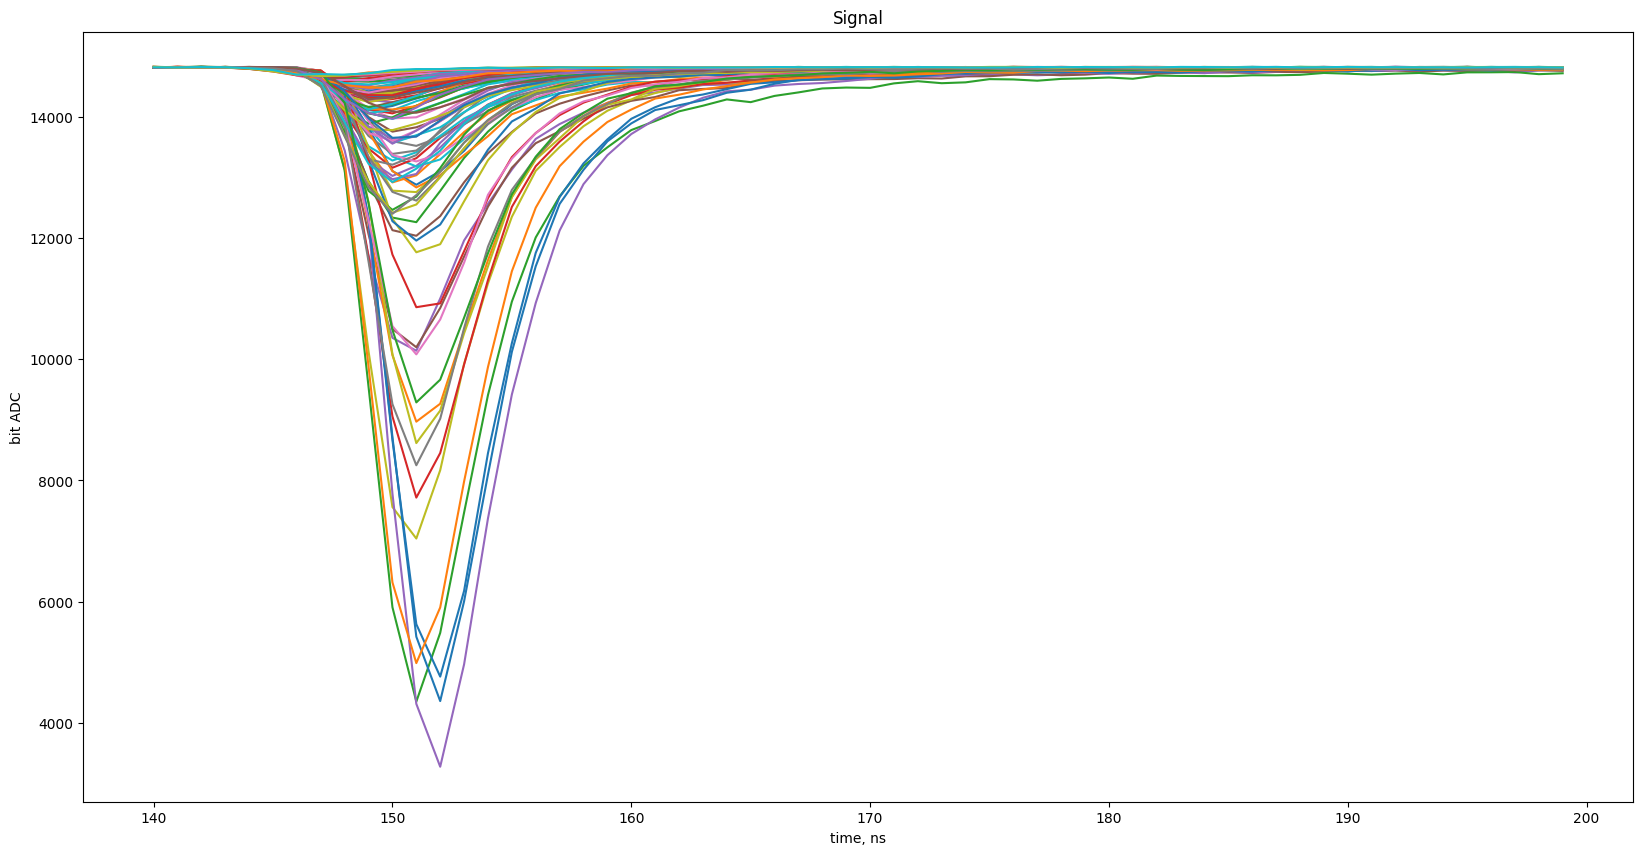

In [ ]:
N=range(0,100)
ax = dataset.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Text(0, 0.5, 'bit ADC')

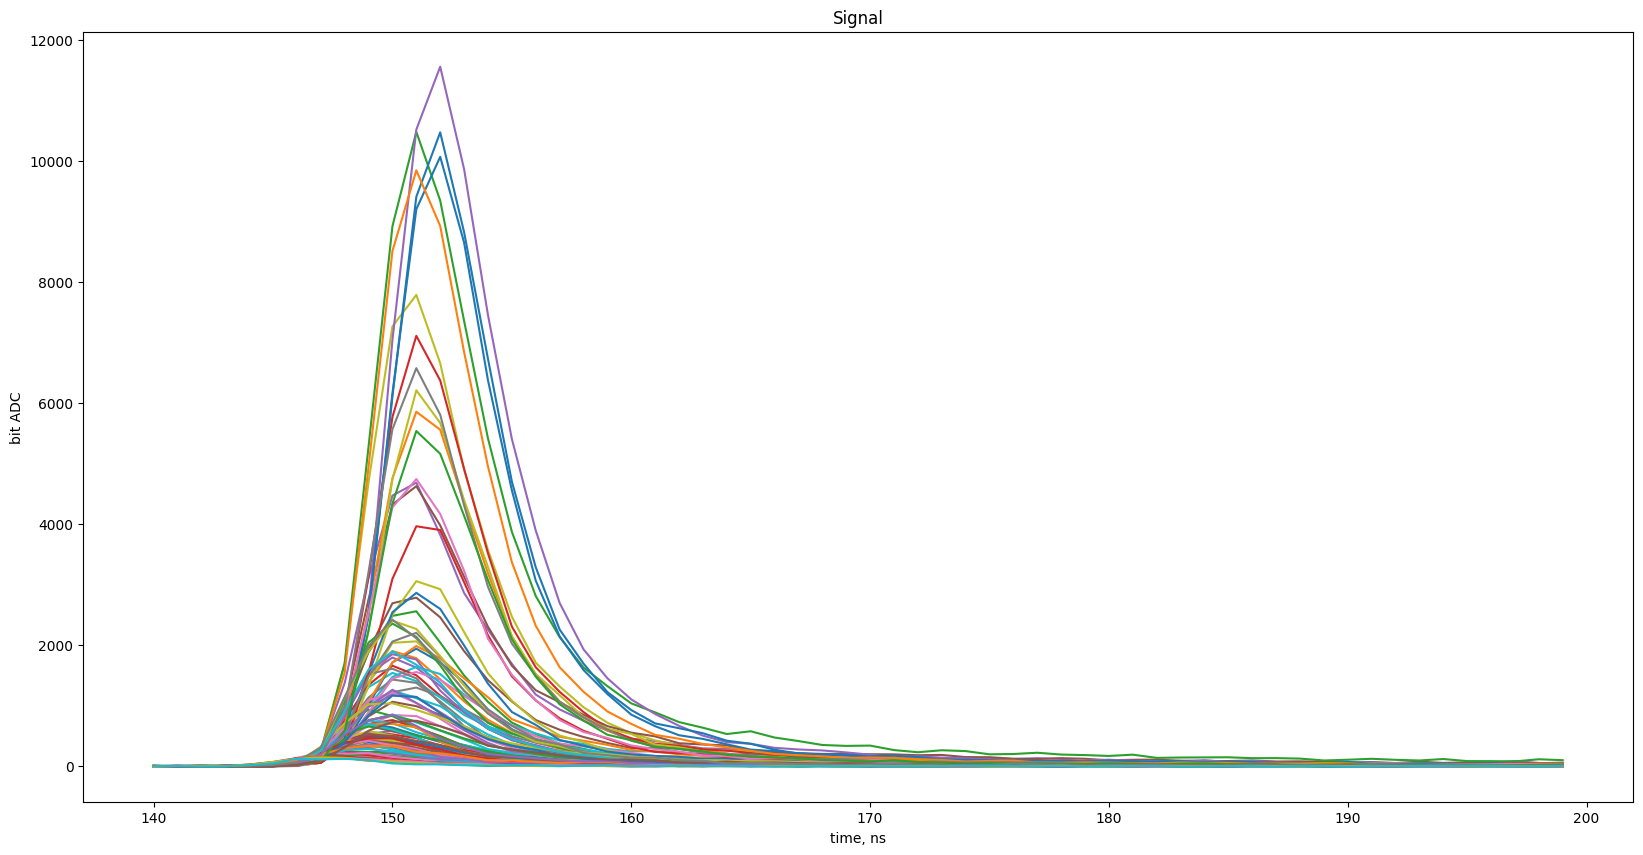

In [ ]:
ax = (2**14-dataset.T[N]-1560)[140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")


In [ ]:
from scipy.integrate import trapezoid

areas = np.array([0]*23479)
amplitudes = np.array([0]*23479)
shorts = np.array([0]*23479)
longs = np.array([0]*23479)

for i in range(23479):
  x = np.array(2**14-dataset.T[i]-1560)
  short = np.array(2**14-dataset.T[i][140:159]-1560)
  lng = np.array(2**14-dataset.T[i][140:200]-1560)
  areas[i] = trapezoid(y=x, x=np.arange(0, len(x)))
  shorts[i] = trapezoid(y=short, x=np.arange(0, len(short)))
  longs[i] = trapezoid(y=lng, x=np.arange(0, len(lng)))
  amplitudes[i] = max(x) - min(x)

psd = (longs - shorts)/longs

df = pd.DataFrame({'s': areas, 'a': amplitudes, 'psd': psd})
df.index.name = 'index'
df

,s,a,psd
index,,,
0,6044,539,0.230584
1,13109,1907,0.109945
2,17991,2566,0.111734
3,5279,573,0.196535
4,12891,1800,0.115952
...,...,...,...
23474,3251,512,0.095541
23475,45755,5774,0.195620
23476,39444,5004,0.215545


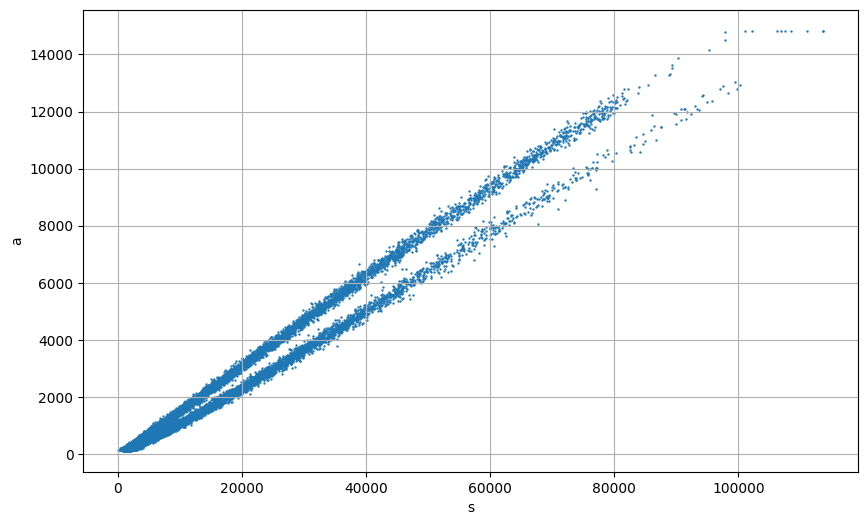

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['s'], df['a'], s=0.5)
plt.xlabel('s')
plt.ylabel('a')
plt.grid()

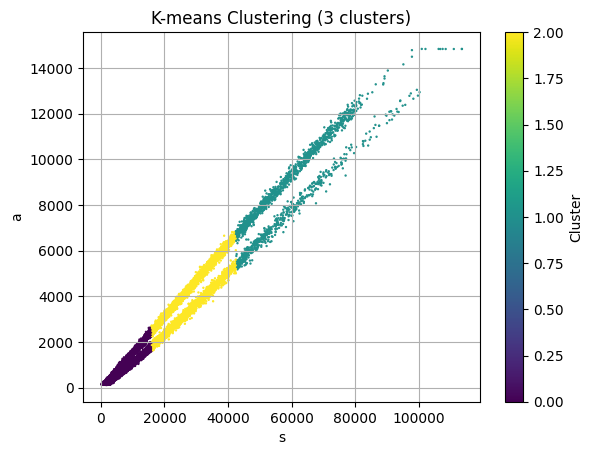

Silhouette Score: 0.6938542532775221
Score: 78403.9965643537


In [ ]:
from sklearn.cluster import KMeans

# Создаем модель KMeans с 3 кластерами
kmeans = KMeans(n_clusters=3, random_state=42)

# Применяем модель к данным
df['cluster'] = kmeans.fit_predict(df[['s', 'a']])

# Визуализация
plt.scatter(df['s'], df['a'], c=df['cluster'], cmap='viridis', s=0.5)
plt.title('K-means Clustering (3 clusters)')
plt.xlabel('s')
plt.ylabel('a')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

X = df[['s', 'a']].values
y = df['cluster'].values
silhouette_avg = silhouette_score(X, y)
calinski_harabasz_index = calinski_harabasz_score(X, y)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Score: {calinski_harabasz_index}")

Вводим определенные соотношения для обратных площадей по графиками сцинтилляций и используем данные о длительности стартовой и финишной зонах частиц

(0.0, 2500.0)

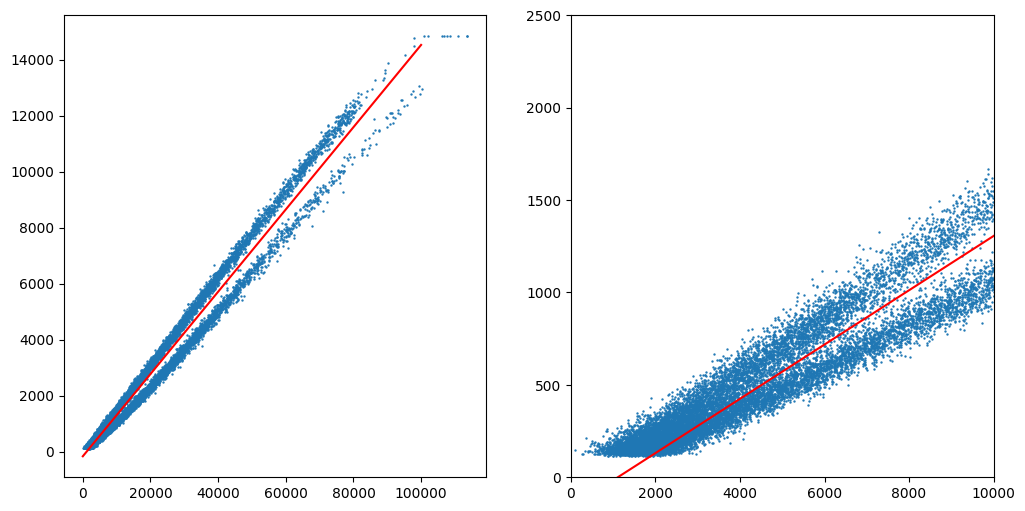

In [ ]:
X = df['s'].values.reshape(-1, 1)
Y = df['a'].values
X = np.hstack((np.ones((X.shape[0], 1)), X))
beta = np.linalg.inv(X.T @ X) @ X.T @ Y
c= beta[0]
b = beta[1]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

x = np.arange(0, 100000, 1)
ax[0].plot(x, b*x + c, c='r')
ax[0].scatter(df['s'], df['a'], s=0.5)
ax[1].plot(x, b*x + c, c='r')
ax[1].scatter(df['s'], df['a'], s=0.5)
ax[1].set_xlim(0, 10000)
ax[1].set_ylim(0, 2500)

<ipython-input-102-e9eeec5bc64a>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


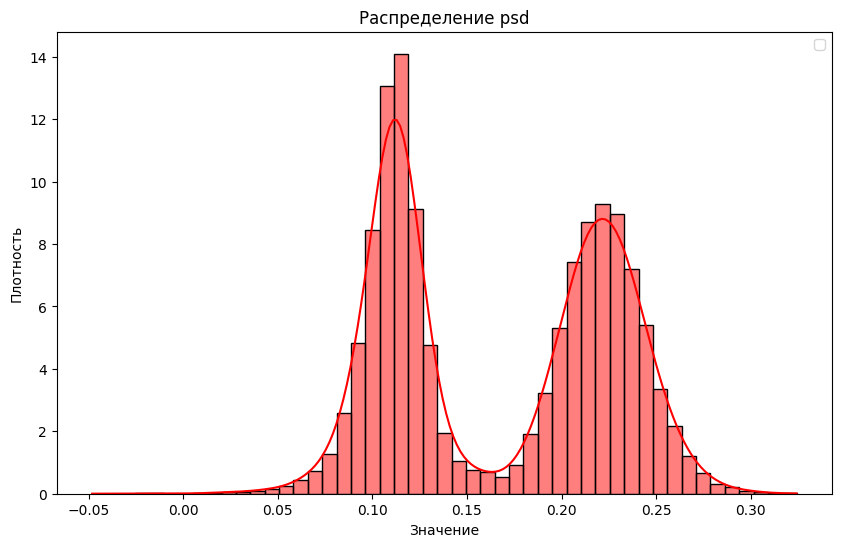

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Распределение проекций для верхнего луча
sns.histplot(df['psd'], kde=True, color='r', stat="density")
ax.set_title('Распределение psd')
ax.set_xlabel('Значение')
ax.set_ylabel('Плотность')
ax.legend()

plt.show()

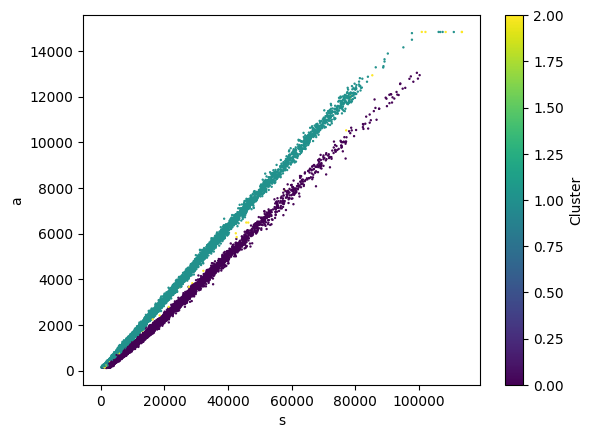

In [ ]:
df['cluster'] = 1
df.loc[(df['psd'] >= 0.14) & (df['psd'] <= 0.17), 'cluster'] = 2
df.loc[df['psd'] > 0.17, 'cluster'] = 0
plt.scatter(df['s'], df['a'], c=df['cluster'], cmap='viridis', s=0.5)
plt.xlabel('s')
plt.ylabel('a')
plt.colorbar(label='Cluster')

(0.0, 2500.0)

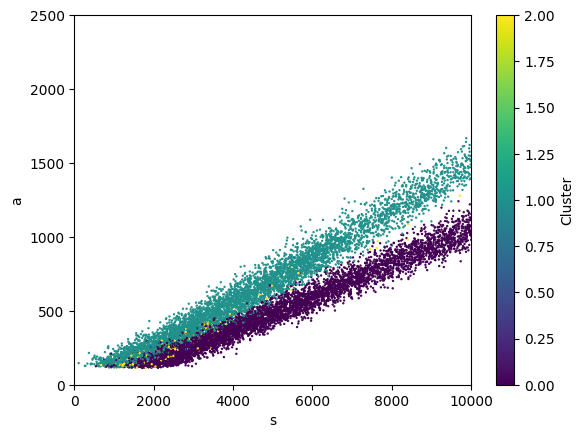

In [ ]:
plt.scatter(df['s'], df['a'], c=df['cluster'], cmap='viridis', s=0.5)
plt.xlabel('s')
plt.ylabel('a')
plt.colorbar(label='Cluster')
plt.xlim(0, 10000)
plt.ylim(0, 2500)

<Axes: xlabel='coef', ylabel='psd'>

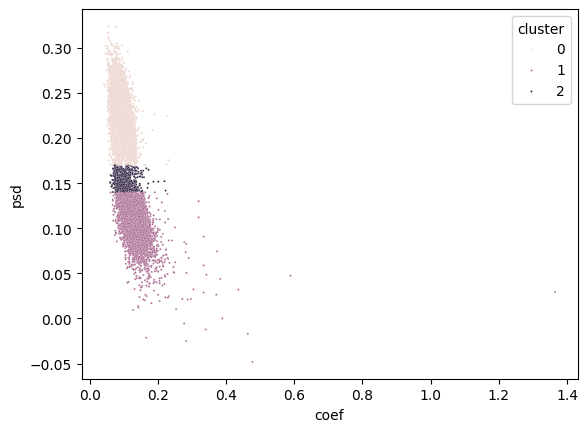

In [ ]:
df['alpha'] = df.apply(lambda row: row['a'] / row['s'], axis=1)
sns.scatterplot(data=df, x='coef', y='psd', hue='cluster', s = 2 )


In [ ]:
X = df[['s', 'a']].values
y = df['cluster'].values
silhouette_avg = silhouette_score(X, y)
calinski_harabasz_index = calinski_harabasz_score(X, y)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Score: {calinski_harabasz_index}")

Silhouette Score: -0.14900049107605176
Score: 137.6657145684626


In [ ]:
out = df['cluster'].sort_values()
out.to_csv('out.csv', header=True, index=True)
out

,cluster
index,
0,0
18300,0
18297,0
9379,0
9380,0
...,...
19583,2
19591,2
19607,2
